In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import re
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Data Preparation

In [53]:
df = pd.read_csv('data/processed/train_1_processed.csv', index_col=None)

#### Select page

In [54]:
page_index = 86431

In [55]:
time_serie = df.loc[[page_index]]

#### Select only time series columns

In [57]:
# Regular expression to match date format "YYYY-MM-DD"
date_pattern = re.compile(r'\d{4}-\d{2}-\d{2}')

# Filter columns based on the regular expression
filtered_columns = [col for col in df.columns if date_pattern.match(col)]

# Create a new DataFrame with only the filtered columns
time_serie = time_serie[filtered_columns]

Save dates for plot later

In [58]:
date_columns = time_serie.columns

#### Time serie inspection

In [59]:
time_serie = time_serie.values.flatten()

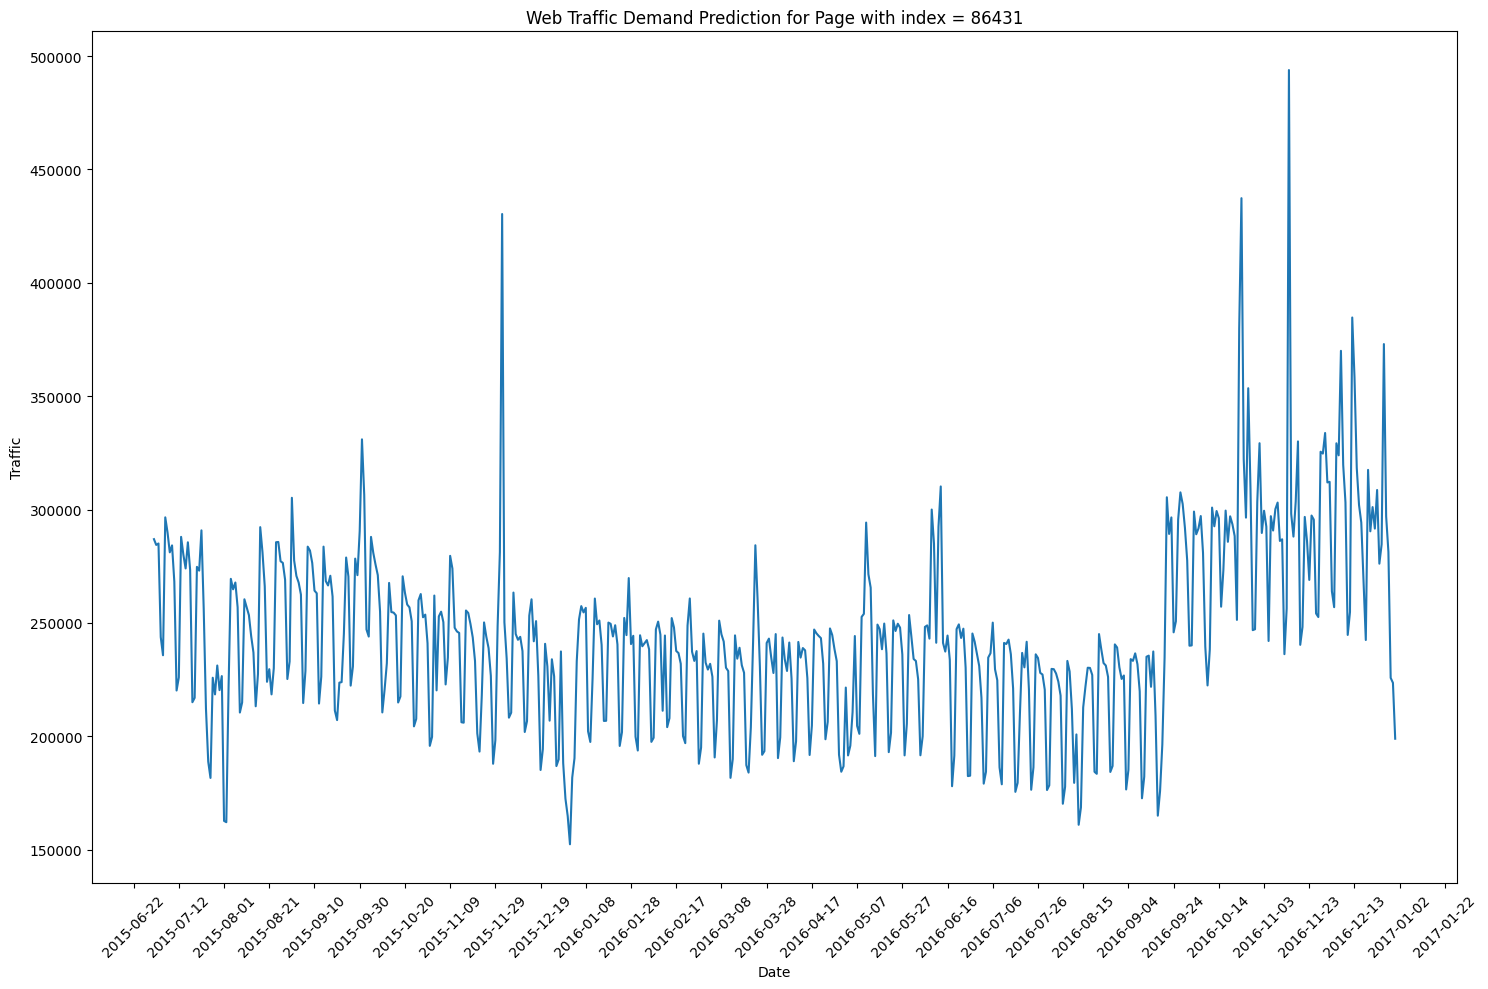

In [60]:
# Creating a DataFrame for test dates and predicted values
plot_inspection_df = pd.DataFrame({
    'Date': pd.to_datetime(date_columns),  # Dates corresponding to the test period
    'Traffic': time_serie,  # Flatten to ensure 1-dimensional
})

plt.figure(figsize=(15, 10))
plt.plot(plot_inspection_df['Date'], plot_inspection_df['Traffic'])
plt.title(f'Web Traffic Demand Prediction for Page with index = {page_index}')
plt.xlabel('Date')
plt.ylabel('Traffic')

# Set major ticks to be every 2 days
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=20))

# Rotate and format the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

#### Split training and test data

In [61]:
train, test = train_test_split(time_serie, test_size=0.2, shuffle=False)

In [62]:
# Split dates too
date_columns = np.array(date_columns)
train_dates = date_columns[:len(train)]
test_dates = date_columns[len(train):len(train) + len(test)]

#### Missing Values Imputation

Missing values are imputed using forward linear interpolation. NAN values before a certain real value will be filled with 0 and the remaining NAN values will be filled using linear interpolation.

In [63]:
# Transform sets in Pandas data frames to use Pandas interpolation function
train = pd.DataFrame(train)
test = pd.DataFrame(test)

Interpolation must be done on training and set separately to avoid data leakage

In [64]:
train = train.interpolate(method='linear', limit_direction='forward', axis=0)
test = test.interpolate(method='linear', limit_direction='forward', axis=0)

In [65]:
# Transform into array series
train = train.values.flatten()
test = test.values.flatten()

# Data Modeling

Train and predict with Walk Forward Validation

In [66]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(10,1,0))
	model_fit = model.fit()
	ypred = model_fit.forecast()[0]
	predictions.append(ypred)
	history.append(test[t])

# Data Evaluation

In [67]:
# Creating a DataFrame for test dates and predicted values
results_df = pd.DataFrame({
    'Date': pd.to_datetime(test_dates),  # Dates corresponding to the test period
    'Actual': test,  # Flatten to ensure 1-dimensional
    'Predicted': predictions  # Flatten to ensure 1-dimensional
})

Compute MSE metric

In [68]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 1668523744.514


Plot observed and predicted time series

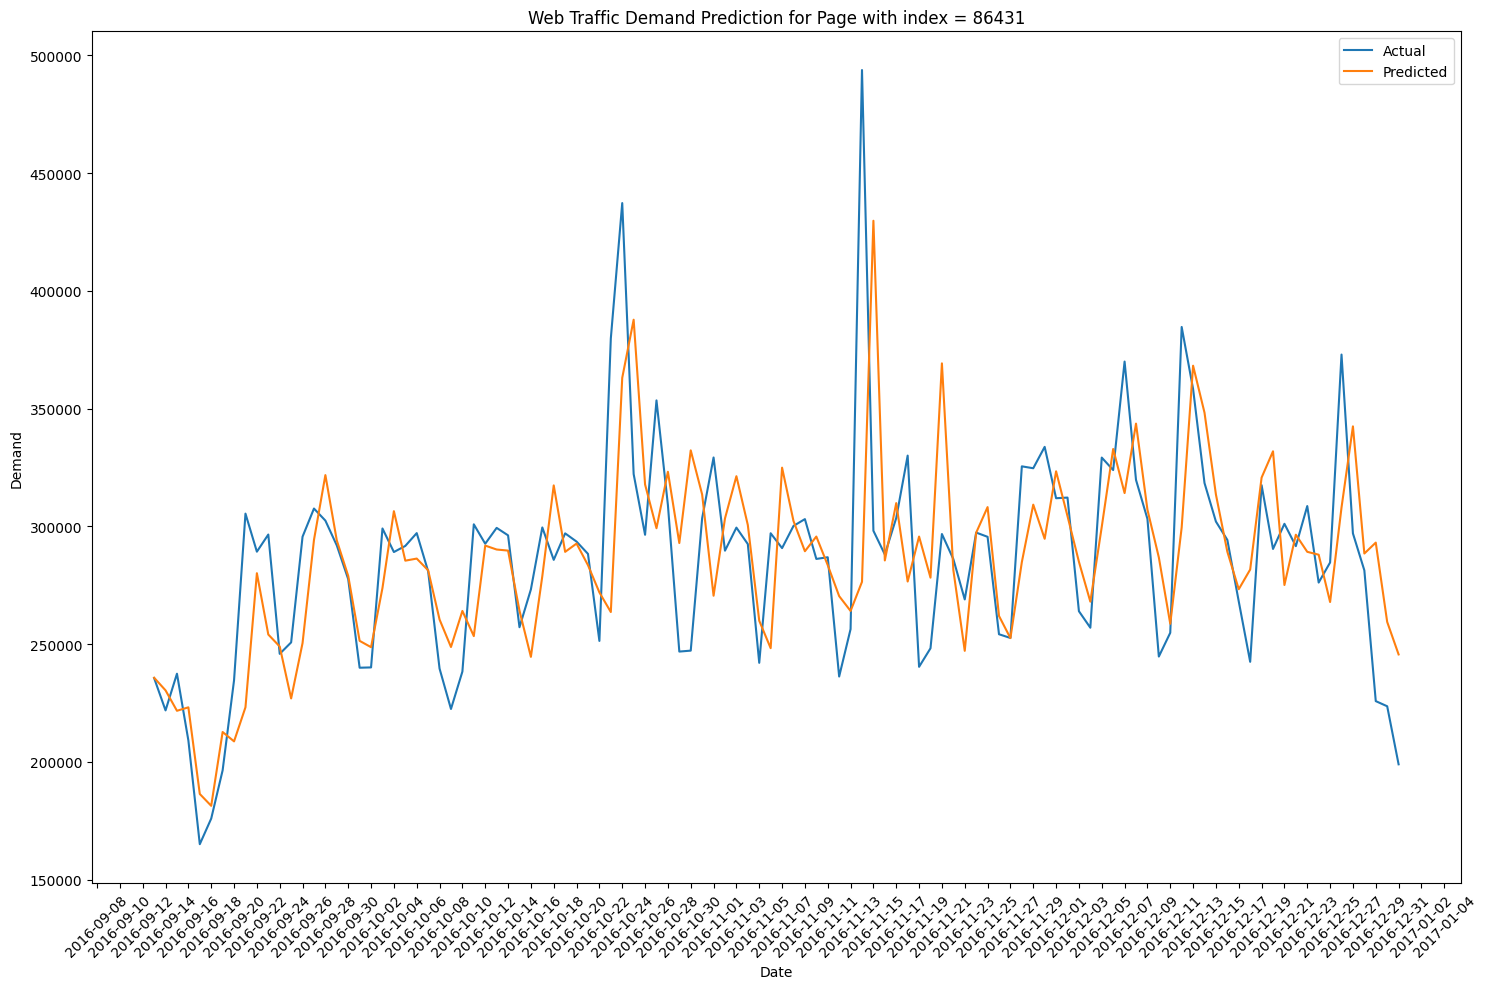

In [69]:
plt.figure(figsize=(15, 10))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted')
plt.title(f'Web Traffic Demand Prediction for Page with index = {page_index}')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()

# Set major ticks to be every 2 days
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Rotate and format the date labels
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()